<a href="https://colab.research.google.com/github/hughesymendes/TIC-27491137/blob/Dip3_model/dip3_sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install lightkurve
!pip install exoplanet
!pip install pymc3==3.8
!pip install corner

     |████████████████████████████████| 501kB 4.7MB/s 
     |████████████████████████████████| 4.5MB 11.2MB/s 
     |████████████████████████████████| 235kB 46.1MB/s 
     |████████████████████████████████| 25.2MB 147kB/s 
     |████████████████████████████████| 2.7MB 46.6MB/s 
  Created wheel for oktopus: filename=oktopus-0.1.2-cp36-none-any.whl size=12779 sha256=7c8843950012d9d6d9e174d4a5d83f53dc4a2ecab217c62b51feb34a93392127
  Stored in directory: /root/.cache/pip/wheels/9b/90/81/098fc66ee56166d63c9a8fc0a9672ae7b3423396a588ec952a
  Created wheel for astroquery: filename=astroquery-0.4-cp36-none-any.whl size=3582510 sha256=191e8c1ecaaad199b2b8e2c6f8b23238791402da20673c53b46cf11d40e4338a
  Stored in directory: /root/.cache/pip/wheels/a3/6d/9d/f6ceddc68de0e4b7a64b56d6e8c8075e6ef6377ec9c05ce128
  Created wheel for uncertainties: filename=uncertainties-3.1.2-cp36-none-any.whl size=96458 sha256=eb7960c3e7d60399d3a031e1706ffd59dafad5fd472720014d4fdca215c1a9a6
  Stored in directory: /root/.

/usr/local/lib/python3.6/dist-packages/lightkurve/search.py:233: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  LightkurveWarning)


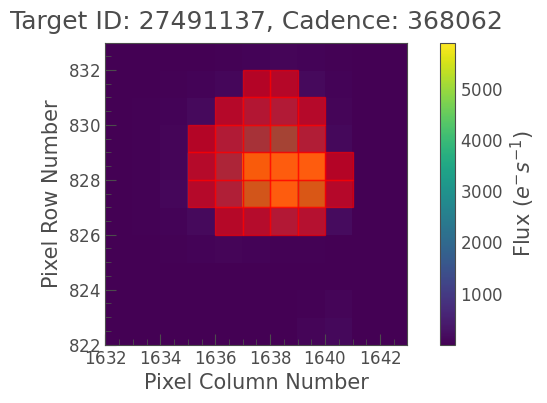

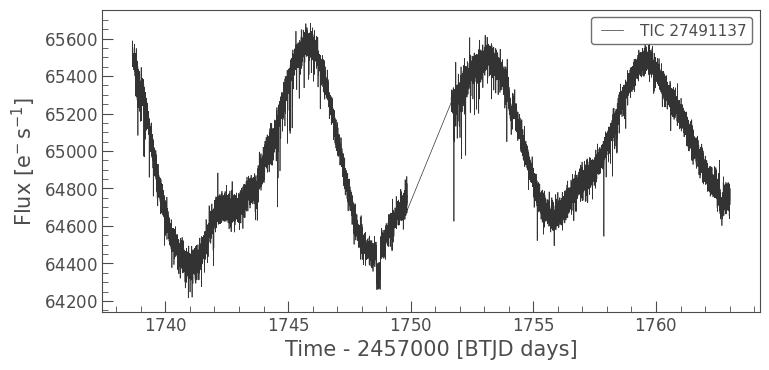

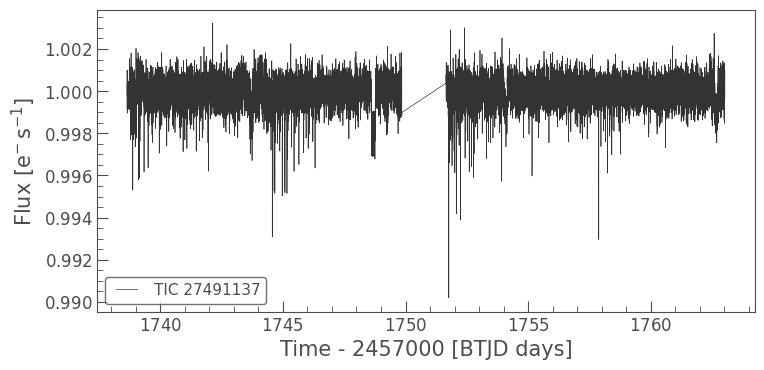

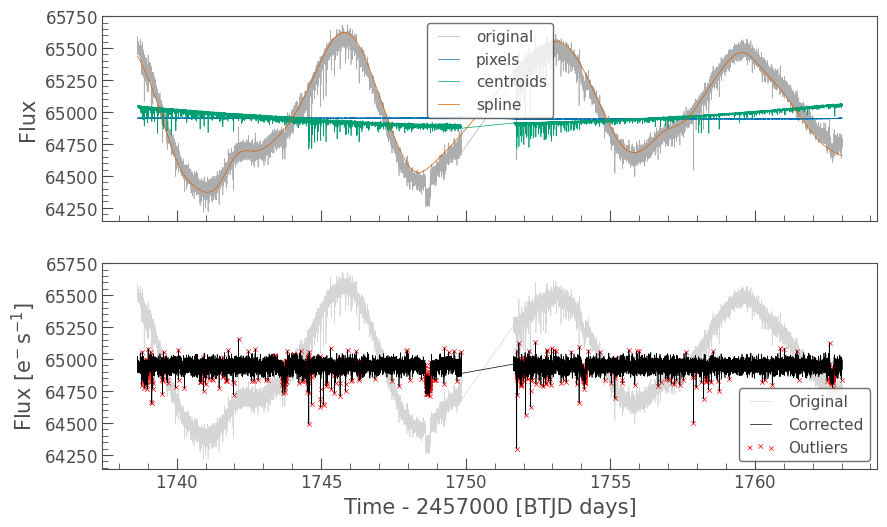

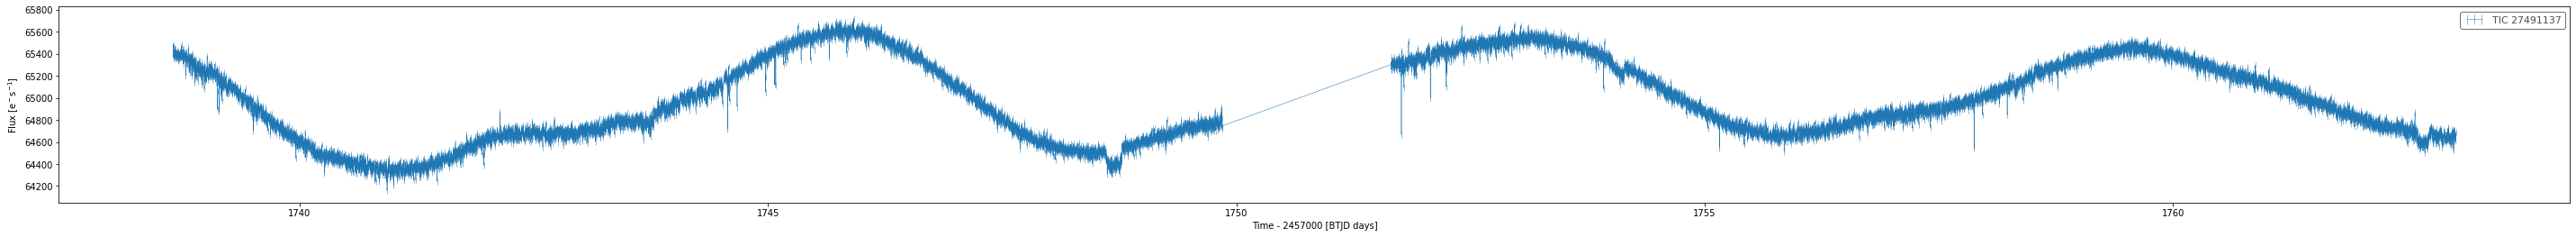

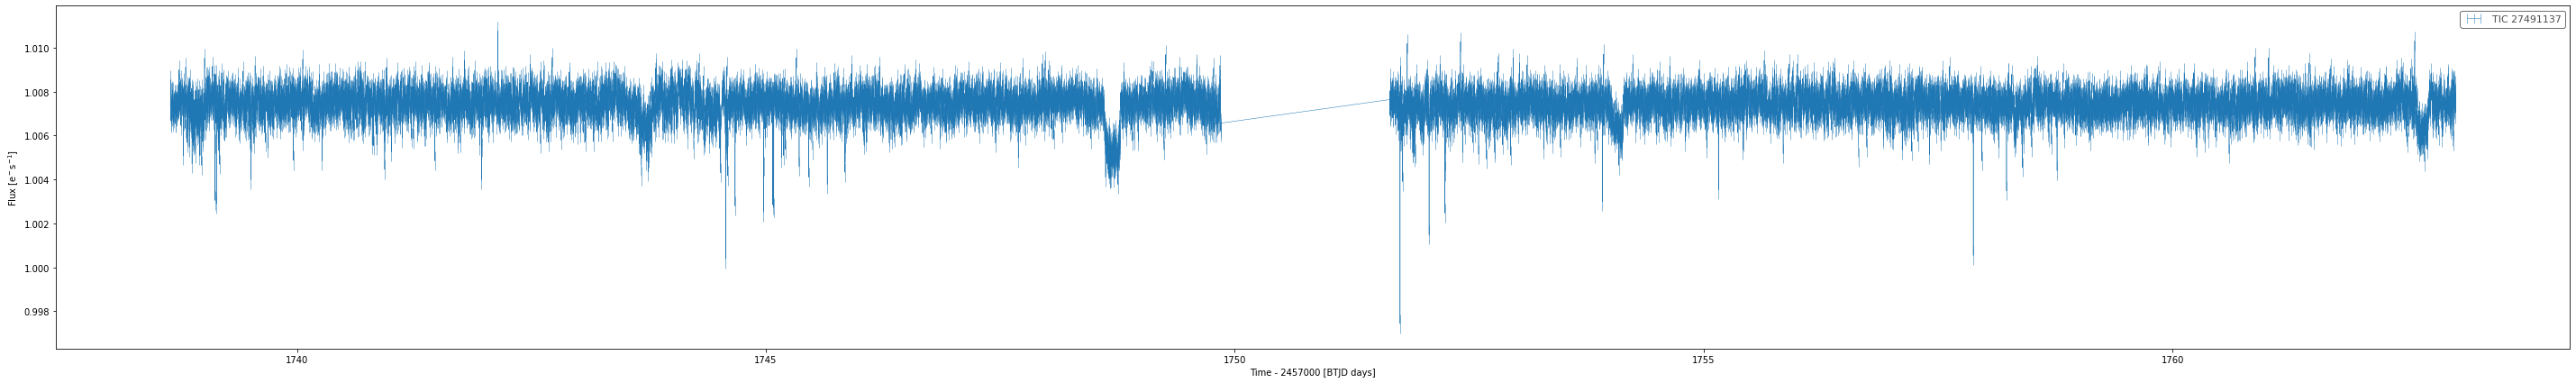

In [2]:

import lightkurve as lk
from lightkurve import search_targetpixelfile
from lightkurve import TessTargetPixelFile
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#downloading data from MAST
tpf = search_targetpixelfile("TIC 27491137").download()
aper = tpf.create_threshold_mask()
tpf.plot(aperture_mask = aper, mask_color = "red")

#Creating Lightcurve from TPF
lc = tpf.to_lightcurve()

#Masking out Argabrightening events
mask = np.isfinite(lc.flux_err)
clipped = lc[mask]

clipped.plot()

flc = clipped.flatten(window_length = 1001).plot()

pixels = tpf.flux[mask][:, ~aper]
dm1 = lk.DesignMatrix(pixels, name='pixels').pca(3).append_constant()

# We'll do a 3D low order polynomial in TIME, COLUMN CENTROID and ROW CENTROID:

r, c = tpf[mask].estimate_centroids()
r, c = r - np.median(r), c - np.median(c)


t = (lc[mask].cadenceno - np.median(lc.cadenceno))/(len(lc.time))


dm2 = lk.DesignMatrix(np.vstack([r, c, r*c, r**2, c**2, r**2*c, c**2*r, r**2*c**2,
                                t*r, t*c, t*r*c, t*r**2, t*c**2, t*r**2*c, t*c**2*r, t*r**2*c**2]).T, name='centroids')

spline = lk.designmatrix.create_spline_matrix(lc[mask].time, n_knots=35)

dm = lk.DesignMatrixCollection([dm1, dm2, spline])

# Make a very hacky cadence mask:
b = lc[mask].flatten(1001).bin(10)
_, m = b.remove_outliers(3, return_mask=True)
cadence_mask = np.interp(lc[mask].time, b.time, m) != 0

#Tried to make a mask by adding all the areas that i wanted to mask, however it errored out saying needed to be 2D?
#mask = (clipped[3300:3900], clipped[7100:7350], clipped[9500:10000], clipped[15700:]) = True

r = lk.RegressionCorrector(lc[mask])
r.correct(dm, sigma=3., cadence_mask=~cadence_mask)

r.diagnose()

# Remove INSTRUMENT systematics
corr = (r.diagnostic_lightcurves['pixels'] + r.diagnostic_lightcurves['centroids']).flux
corr -= np.median(corr)
clc = (lc[mask] - corr)

fig, ax = plt.subplots(figsize=(50, 4))
(clc).errorbar(ls='-', ax=ax)

# Divide through by STELLAR flux
stellar_flux = r.diagnostic_lightcurves['spline'].flux + np.median(clc.flux)

fig, ax = plt.subplots(figsize=(50, 7))
(clc/stellar_flux).errorbar(ls='-', ax=ax)

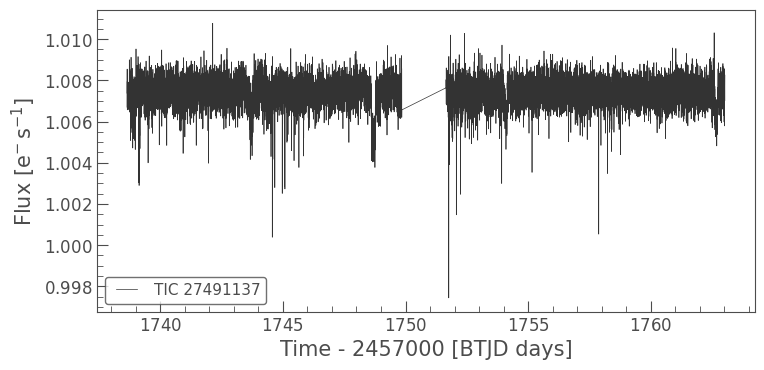

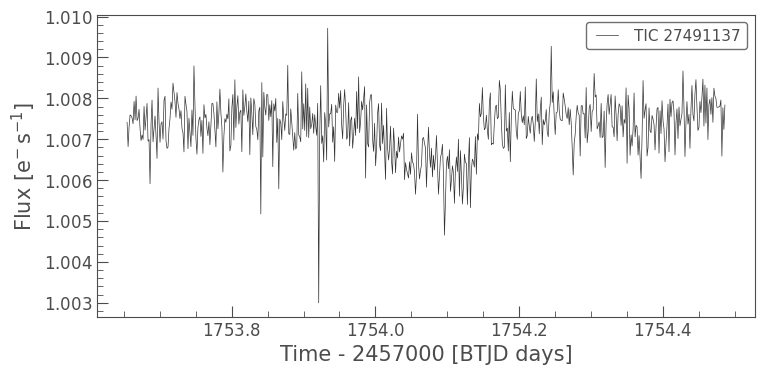

In [5]:
clean_lc = (clc/stellar_flux)
clean_lc.plot()
 
dip3 = clean_lc[9500:10100]
dip3.plot()


dx = np.append( np.array( [], dtype="float64" ),dip3.time )
dy = np.append( np.array( [], dtype="float64" ), dip3.flux - 1.0075 )
dy_err = np.append( np.array( [], dtype="float64" ), dip3.flux_err )

In [8]:
dx

array([1753.65447996, 1753.65586883, 1753.6572577 , 1753.65864657,
       1753.66003544, 1753.66142431, 1753.66281318, 1753.66420205,
       1753.66559092, 1753.66697979, 1753.66836866, 1753.66975753,
       1753.6711464 , 1753.67253527, 1753.67392414, 1753.67531301,
       1753.67670188, 1753.67809075, 1753.67947962, 1753.68086849,
       1753.68225736, 1753.68364623, 1753.6850351 , 1753.68642397,
       1753.68781284, 1753.68920171, 1753.69059058, 1753.69197945,
       1753.69336832, 1753.69475719, 1753.69614606, 1753.69753493,
       1753.6989238 , 1753.70031266, 1753.70170153, 1753.7030904 ,
       1753.70447927, 1753.70586814, 1753.70725701, 1753.70864588,
       1753.71003475, 1753.71142362, 1753.71281249, 1753.71420136,
       1753.71559023, 1753.7169791 , 1753.71836797, 1753.71975684,
       1753.72114571, 1753.72253458, 1753.72392345, 1753.72531232,
       1753.72670119, 1753.72809006, 1753.72947893, 1753.7308678 ,
       1753.73225667, 1753.73364554, 1753.73503441, 1753.73642

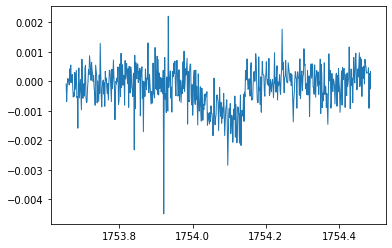

In [6]:
plt.plot(dx, dy, color="C0", lw=1)

/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


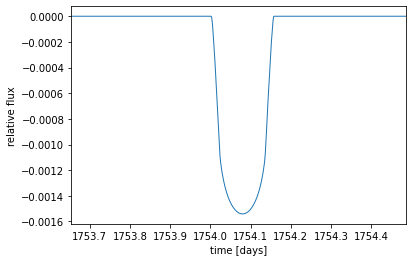

In [16]:
import numpy as np
import exoplanet as xo

# The light curve calculation requires an orbit
orbit = xo.orbits.KeplerianOrbit(period= 10, t0 =1754.08, r_star = 0.78, m_star = 0.87)

# Compute a limb-darkened light curve using starry
t = np.linspace(1753.65447996,1754.48641354, 600)
#found values from a paper for Kepler and TESS that gives a=0.4984, b= 0.1939 (using quadratic law).
# 'u' seems to be linear but is only given as one value whereas 'u' here is 2D so I've input values 
# In between the two closest stellar temps. paper-- https://arxiv.org/pdf/0912.2274.pdf

u = [0.5, 0.17]
light_curve = (
    xo.LimbDarkLightCurve(u)
    .get_light_curve(orbit=orbit, r=0.0275, t=t, texp=0.02)
    .eval()
)
# Note: the `eval` is needed because this is using Theano in
# the background

plt.plot(t, light_curve, color="C0", lw=1)
plt.ylabel("relative flux")
plt.xlabel("time [days]")
_ = plt.xlim(t.min(), t.max())

/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
optimizing logp for variables: [b, r, u, logP, t0, mean]


/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this wil

/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Desired error not necessarily achieved due to precision loss.
logp: 3529.881291707058 -> 3597.4259348915766


IndexError: ignored

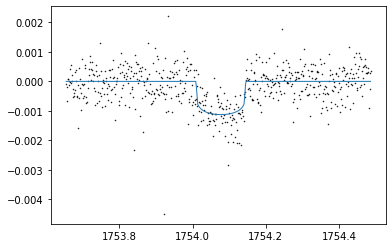

In [21]:
import pymc3 as pm

with pm.Model() as model:

    # The baseline flux
    mean = pm.Normal("mean", mu=0.0, sd=1.0)

    # The time of a reference transit for each planet
    #Mu seems to be centre of transit.
    #For random.uniform "Samples are uniformly distributed over the half-open interval [low, high) (includes low, but excludes high)"
    t0 = pm.Normal("t0", mu=1754.08, sd=1.0, shape=1)

    # The log period; also tracking the period itself
    logP = pm.Uniform("logP", lower=0,upper=6,testval=1)
    period = pm.Deterministic("period", pm.math.exp(logP))

    # The Kipping (2013) parameterization for quadratic limb darkening paramters
    u = xo.distributions.QuadLimbDark("u", testval=np.array([0.05, 0.017]))

    r = pm.Uniform("r", lower=0.01, upper=0.06, shape=1)
    b = xo.distributions.ImpactParameter("b", ror=r, shape=1)

    # Set up a Keplerian orbit for the planets
    orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0, b=b)

    # Compute the model light curve using starry
    light_curves = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit, r=r, t=t)
    light_curve = pm.math.sum(light_curves, axis=-1) + mean

    # Here we track the value of the model light curve for plotting
    # purposes
    pm.Deterministic("light_curves", light_curves)

    # In this line, we simulate the dataset that we will fit
    y = dy
    #y += dy_err * np.random.randn(len(y))

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=light_curve, sd=dy_err, observed=y)

    # Fit for the maximum a posteriori parameters given the simuated
    # dataset
    map_soln = xo.optimize(start=model.test_point)


plt.plot(t, y, ".k", ms=1, label="data")
for i, l in enumerate("bc"):
    plt.plot(
        t, map_soln["light_curves"][:, i], lw=1, label="planet {0}".format(1)
    )
plt.xlim(t.min(), t.max())
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.legend(fontsize=10)
_ = plt.title("map model")

    

In [22]:
np.random.seed(42)
with model:
    trace = pm.sample(
        tune=3000,
        draws=3000,
        start=map_soln,
        chains=4,
        step=xo.get_dense_nuts_step(target_accept=0.9),
    )

/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Sequential sampling (4 chains in 1 job)
NUTS: [b, r, u, logP, t0, mean]
Sampling chain 0, 0 divergences:   0%|          | 0/6000 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Sampling chain 3, 0 divergences: 100%|██████████| 6000/6000 [02:57<00:00, 33.80it

In [23]:
pm.summary(trace, varnames=["period", "t0", "r", "b", "u", "mean"])

/usr/local/lib/python3.6/dist-packages/pymc3/stats/__init__.py:21: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.9
  "pymc3 3.9".format(old=old, new=new)
/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
period,13.117,15.088,4.151,36.614,0.367,0.260,1691.0,1691.0,2287.0,2182.0,1.0
t0[0],1754.078,0.002,1754.075,1754.081,0.000,0.000,6622.0,6622.0,7140.0,5346.0,1.0
r[0],0.032,0.002,0.029,0.035,0.000,0.000,2047.0,1959.0,2758.0,2245.0,1.0
b[0],0.450,0.266,0.000,0.855,0.006,0.004,2305.0,2156.0,1940.0,2288.0,1.0
u[0],0.319,0.245,0.000,0.761,0.004,0.003,4322.0,3456.0,4779.0,4314.0,1.0
u[1],0.214,0.312,-0.316,0.817,0.004,0.003,5910.0,5910.0,5665.0,5065.0,1.0
mean,-0.000,0.000,-0.000,0.000,0.000,0.000,8811.0,8058.0,8812.0,7500.0,1.0


In [0]:
!pip install corner


INFO (theano.gof.compilelock): Refreshing lock /root/.theano/compiledir_Linux-4.19.104+-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock


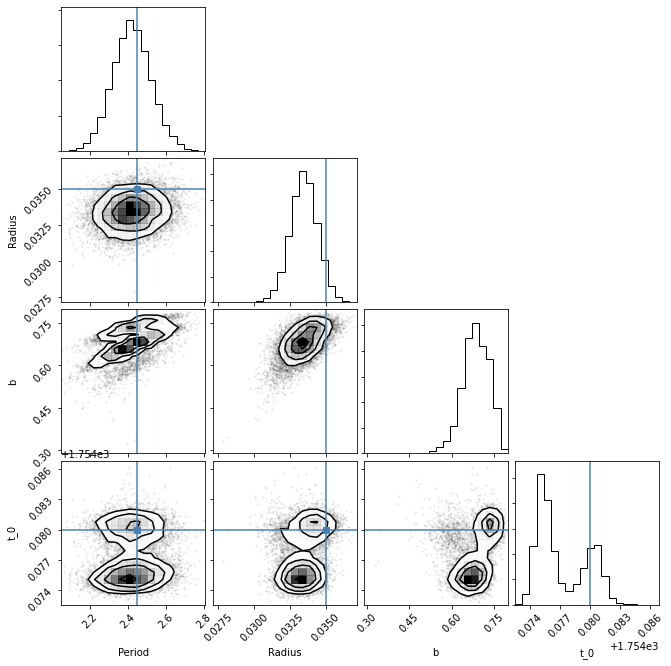

In [39]:
import corner

samples = pm.trace_to_dataframe(trace, varnames=["logP", "r", "b", "t0"])
truth = np.concatenate(xo.eval_in_model([logP, r, b, t0], model.test_point, model=model))
corner.corner(
    samples, truths=truth, labels=["Period", "Radius", "b", "t_0"]
);